In [1]:
import numpy as np
import pandas as pd
import os, sys, glob, shutil 
from config import *
from plotting_functions import *
import analysis_helpers as helper
sys.path.insert(0,'../..')
%load_ext autoreload
%autoreload 2
from scipy.ndimage import zoom
from sklearn.linear_model import LinearRegression
from TPHATE.tphate import tphate
import phate
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
import itertools
import inspect
from scipy.spatial.distance import pdist, cdist,squareform
from scipy.stats import zscore, wasserstein_distance, ttest_1samp, ttest_rel, ttest_ind, sem,f_oneway, spearmanr, pearsonr
from sklearn.decomposition import PCA,FactorAnalysis
from sklearn.manifold import Isomap
import matplotlib as mpl
import scprep
from sklearn.datasets import make_swiss_roll, make_s_curve
import matplotlib 
import pydiffmap as pdm
matplotlib.rcParams['pdf.fonttype'] = 42 
matplotlib.rcParams["pdf.use14corefonts"] = True
sns.set_context(context_params)

In [2]:
def generate_temp_kernel(progression, dropoff=100, norm=True):
    n_samples=len(progression)
    M = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            if 0 < abs(i-j) < dropoff:
                M[i,j]=1-abs(progression[i]-progression[j])
                M[j,i]=1-abs(progression[j]-progression[i])
    # row normalize to turn to probabilities
    if norm:
        for row in M:
            if np.sum(row) == 0: # this should never be true
                continue
            row[:] /= np.sum(row)
    return M 

In [3]:
def embed_custom_kernel_tphate(data, progression, dropoff=100, n_components=2,plot=True):
    idx = np.argsort(progression)
    progression1 = progression[idx]
    data1 = data[idx]
    temp_kernel = generate_temp_kernel(progression1, dropoff)
    op = tphate.TPHATE(verbose=0, view2=temp_kernel, n_components=n_components)
    ebd = op.fit_transform(data1)
    ph_dm = op.phate_diffop
    diffop=op.diff_op
    pot=op.diff_potential
    if plot:
        fig,ax=plt.subplots(2,2,figsize=(6,6))
        ax=ax.ravel()
        sns.heatmap(temp_kernel,ax=ax[0],cbar=True,square=True,xticklabels=[], yticklabels=[])
        ax[0].set(title='temporal kernel')
        
        sns.heatmap(ph_dm,ax=ax[1],cbar=True,square=True,xticklabels=[], yticklabels=[])
        ax[1].set(title='phate')

        sns.heatmap(diffop,ax=ax[2],cbar=True,square=True,xticklabels=[], yticklabels=[])
        ax[2].set(title='tphate')

        sns.heatmap(pot,ax=ax[3],cbar=True,square=True,xticklabels=[], yticklabels=[])
        ax[3].set(title='potential')
        fig.tight_layout()
    return ebd, progression1
    

/gpfs/milgram/project/casey/elb77/conda_envs/rtcloud_av1/lib/python3.7/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


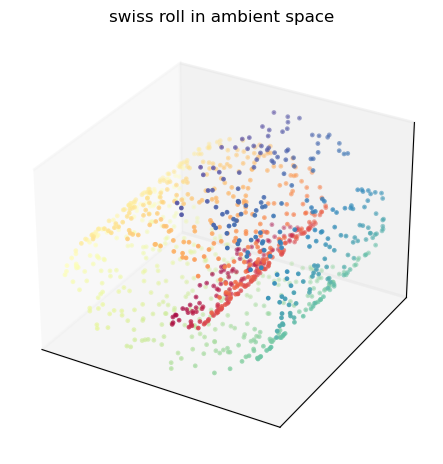

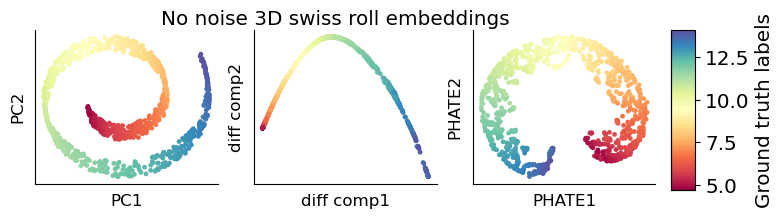

In [4]:
sw_data, sw_color = make_swiss_roll(1000, random_state=4, noise=0)
cmap='Spectral'

scprep.plot.scatter3d(sw_data,c=sw_color,cmap=cmap,s=2,title='swiss roll in ambient space',ticks=False,colorbar=False,
                      filename='./plots/SW_no_noise.pdf')
sw2d = PCA().fit_transform(sw_data)
# embed with diffusion maps
sw_dm2d = pdm.diffusion_map.DiffusionMap.from_sklearn(n_evecs=2).fit_transform(sw_data)
# embed with PHATE
ph_op = phate.PHATE(n_components=2,verbose=0)
sw_ph2d = ph_op.fit_transform(sw_data)
# embed with tphate
sw_tph2d, tphcolors = embed_custom_kernel_tphate(sw_data, sw_color, dropoff=100, n_components=2, plot=False)
fig,axes = plt.subplots(1,3,figsize=(8,2))

# fig.subplots_adjust(top=0.8)
axes=axes.ravel()
data=[sw2d, sw_dm2d, sw_ph2d, sw_tph2d]
cs = [sw_color, sw_color, sw_color, tphcolors]
titles=['PCA', 'Diffusion maps', 'PHATE', 'TPHATE']
axis_labels=['PC', 'diff comp', 'PHATE', 'TPHATE']
for i in range(len(axes)):
    scprep.plot.scatter2d(data[i],c=cs[i],cmap=cmap,s=2,label_prefix=axis_labels[i],ax=axes[i],ticks=False,colorbar=False)

cmap1 = cm.get_cmap("Spectral")

# need to normalize because color maps are defined in [0, 1]
norm = colors.Normalize(np.min(sw_color), np.max(sw_color))
cooolors = cm.ScalarMappable(norm=norm, cmap=cmap1)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.08, 0.03, 0.8])
fig.colorbar(cooolors, cax=cbar_ax)
cbar_ax.set_ylabel('Ground truth labels')
cbar_ax.set_xticklabels([])

sns.despine()
fig.suptitle('No noise 3D swiss roll embeddings')
fig.savefig('plots/SW_no_noise_embeddings.pdf', format='pdf', transparent=True)


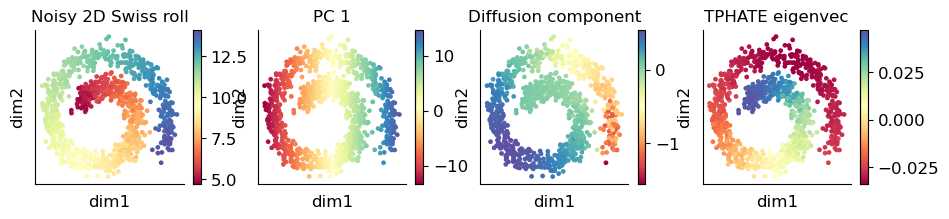

In [5]:
sw_data, sw_color = make_swiss_roll(1000, random_state=4, noise=1)
sw2d = PCA().fit_transform(sw_data)

cmap='Spectral'
# embed with diffusion maps
sw_dm2d = pdm.diffusion_map.DiffusionMap.from_sklearn(n_evecs=2, epsilon='bgh', neighbor_params={'n_jobs': -1, 'algorithm': 'kd_tree'}).fit_transform(sw2d)
# embed with PHATE
ph_op = phate.PHATE(n_components=2, verbose=0)
sw_ph2d = ph_op.fit_transform(sw2d)
# embed with tphate
sw_tph2d, tphcolors = embed_custom_kernel_tphate(sw2d, sw_color, dropoff=100, n_components=2, plot=False)
tph_pc=PCA().fit_transform(sw_tph2d)
fig, axes = plt.subplots(1,4,figsize=(11,2))
idx=np.argsort(sw_color)
# fig.subplots_adjust(top=0.8)
axes=axes.ravel()
data=[sw2d, sw2d, sw2d, sw2d[idx]]
cs = [sw_color,  sw2d[:,0], sw_dm2d[:,0],sw_tph2d[:,0]]
titles=['Noisy 2D Swiss roll',  'PC 1', 'Diffusion component','TPHATE eigenvec']
axis_labels=['dim', 'dim', 'dim', 'dim']
for i in range(len(axes)):
    scprep.plot.scatter2d(data[i],c=cs[i],cmap=cmap,s=2,label_prefix=axis_labels[i], ax=axes[i],title=titles[i],ticks=False,colorbar=True)


sns.despine()
fig.savefig('plots/high_noise_swiss_roll.pdf', format='pdf', transparent=True)



/gpfs/milgram/project/casey/elb77/conda_envs/rtcloud_av1/lib/python3.7/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


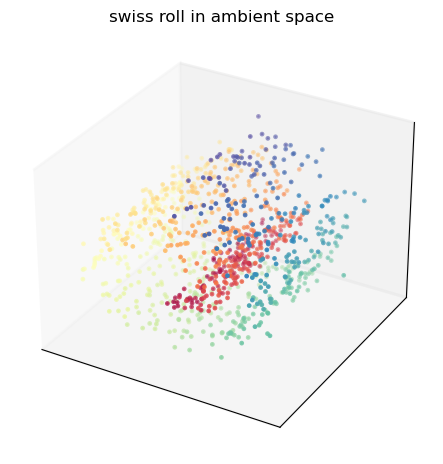

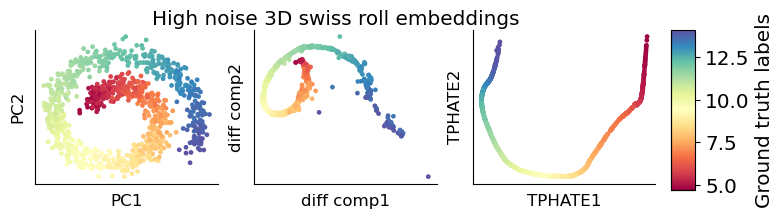

In [6]:
sw_data, sw_color = make_swiss_roll(1000, random_state=4, noise=1)

scprep.plot.scatter3d(sw_data,c=sw_color,cmap=cmap,s=2,title='swiss roll in ambient space',ticks=False,colorbar=False,
                      filename='./plots/SW_high_noise.pdf')

sw2d = PCA().fit_transform(sw_data)
cmap='Spectral'
# embed with diffusion maps
sw_dm2d = pdm.diffusion_map.DiffusionMap.from_sklearn(n_evecs=2, epsilon='bgh', neighbor_params={'n_jobs': -1, 'algorithm': 'kd_tree'}).fit_transform(sw_data)
# embed with tphate
sw_tph2d, tphcolors = embed_custom_kernel_tphate(sw_data, sw_color, dropoff=100, n_components=2, plot=False)
fig,axes = plt.subplots(1,3,figsize=(8,2))

# fig.subplots_adjust(top=0.8)
axes=axes.ravel()
data=[sw2d, sw_dm2d, sw_tph2d]
cs = [sw_color, sw_color, tphcolors]
titles=['PCA', 'Diffusion maps',  'TPHATE']
axis_labels=['PC', 'diff comp', 'TPHATE']
for i in range(len(axes)):
    scprep.plot.scatter2d(data[i],c=cs[i],cmap=cmap,s=2,label_prefix=axis_labels[i],ax=axes[i],ticks=False,colorbar=False)

cmap1 = cm.get_cmap("Spectral")

# need to normalize because color maps are defined in [0, 1]
norm = colors.Normalize(np.min(sw_color), np.max(sw_color))
cooolors = cm.ScalarMappable(norm=norm, cmap=cmap1)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.08, 0.03, 0.8])
fig.colorbar(cooolors, cax=cbar_ax)
cbar_ax.set_ylabel('Ground truth labels')
cbar_ax.set_xticklabels([])

sns.despine()
fig.suptitle('High noise 3D swiss roll embeddings')
fig.savefig('plots/SW_high_noise_embeddings.pdf', format='pdf', transparent=True)

